## Задание 1. Линейная регрессия (LinReg) и дисперсионный анализ (ANOVA)

In [1]:
# %pip install -r requirements.txt 

In [2]:
from itertools import combinations
from typing import Tuple, Dict

import pandas as pd
import numpy as np
from sklearn import datasets
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

### [1] Выбрать один из датасетов из перечня.

In [3]:
iris = datasets.load_iris()

Выбрать три класса и четыре количественных (недискретных) признака. Сформировать на их основе «отфильтрованный» датасет для дальнейшего анализа, удалив из датасета все объекты, для которых не определены значения хотя бы одного из выбранных четырех количественных признаков.

In [4]:
df = pd.DataFrame(iris.data, columns=iris.feature_names)
df['target'] = iris.target
df['target_name'] = df['target'].apply(lambda x: iris.target_names[x])

feature_columns = [col for col in df.columns if col not in ['target', 'target_name']]
class_names = iris.target_names.tolist()

objects_by_class: Dict[str, pd.DataFrame] = {
    cls: df[df["target_name"] == cls][feature_columns]
    for cls in class_names
}

### [2] Вывести в табличной форме статистику по датасету, включая
- Размерность всего датасета
- Количество признаков
- Количество целевых классов и объектов в каждом из классов
- Процент объектов с неопределенными признаками
- Иные ключевые характеристики датасета

In [5]:
def dataset_overview(df: pd.DataFrame) -> None:
    """
    Вывод основных характеристик датасета: размер, количество признаков,
    классов, объекты по классам, процент пропусков.
    """
    print(f"Размер датасета: {df.shape}")
    print(f"Количество признаков: {len(feature_columns)}")
    print(f"Количество классов: {df['target'].nunique()}")
    print("\nКоличество объектов по классам:")
    print(df['target_name'].value_counts())
    percent_missing = (df.isnull().sum() / len(df) * 100).round(2)
    print("\nПроцент пропусков по признакам:")
    print(percent_missing)
    display (df.describe())

In [6]:
dataset_overview(df)

Размер датасета: (150, 6)
Количество признаков: 4
Количество классов: 3

Количество объектов по классам:
target_name
setosa        50
versicolor    50
virginica     50
Name: count, dtype: int64

Процент пропусков по признакам:
sepal length (cm)    0.0
sepal width (cm)     0.0
petal length (cm)    0.0
petal width (cm)     0.0
target               0.0
target_name          0.0
dtype: float64


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333,1.000000
std,0.828066,0.435866,1.765298,0.762238,0.819232
min,4.300000,2.000000,1.000000,0.100000,0.000000
25%,5.100000,2.800000,1.600000,0.300000,0.000000
50%,5.800000,3.000000,4.350000,1.300000,1.000000
75%,6.400000,3.300000,5.100000,1.800000,2.000000
max,7.900000,4.400000,6.900000,2.500000,2.000000


### [3] Выполнить визуализацию датасета по всем парам выбранных количественных переменных, обозначая:
- в графиках с разными парами переменных объекты из разных классов различными по
форме и цвету точками,
- в графиках с одной и той же парой переменных – гистограммы с достаточным числом
разбиений (обычно – не менее 20), либо плотности распределения переменной по оси
признака.

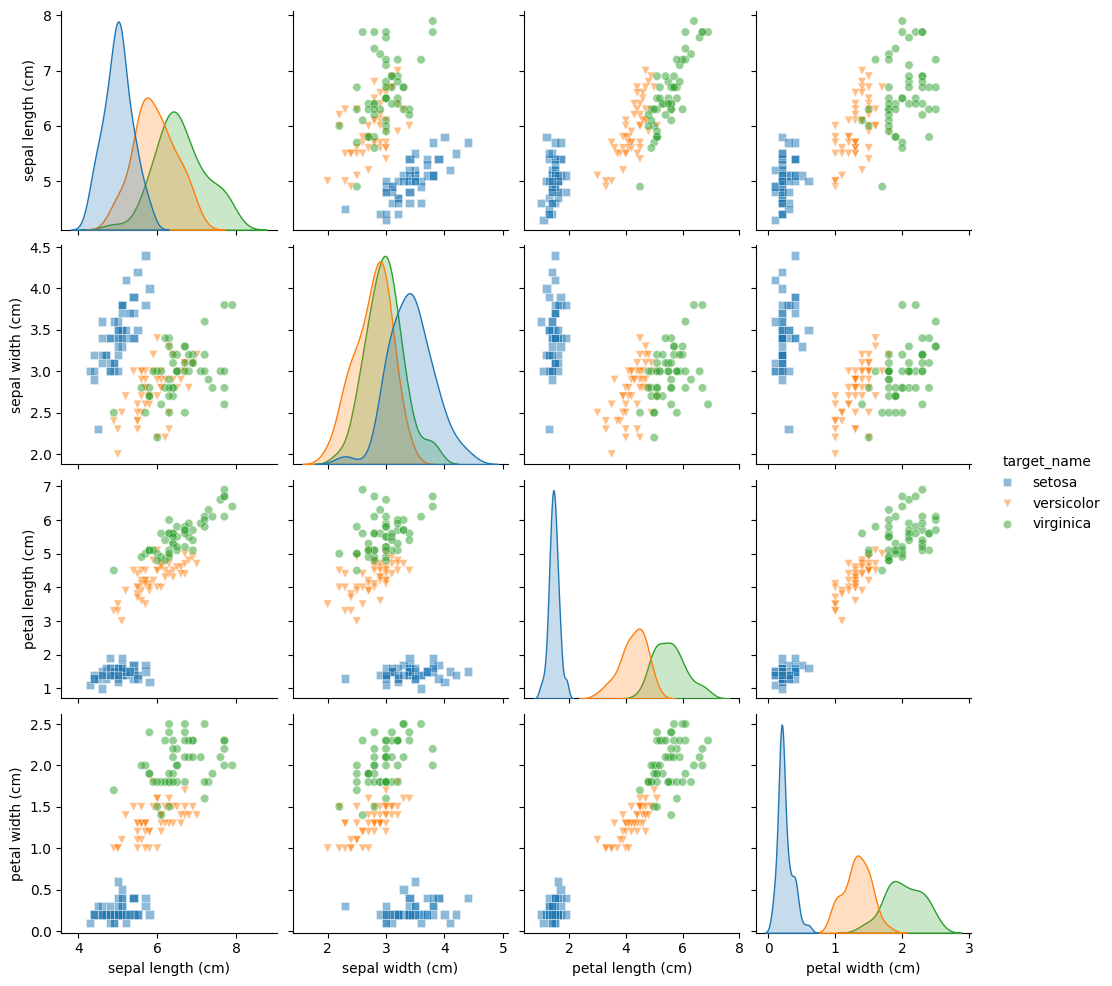

In [7]:
sns.pairplot(df.drop(columns='target'), hue='target_name', markers=['s', 'v', 'o'],  plot_kws={'alpha': 0.5} )
plt.show()

### [4] В табличном варианте оценить степень сопряженности пар признак-признак на всем датасете, используя коэффициенты корреляции Пирсона и Спирмана, с p-критериями для коэффициентов. 
В табличном варианте также оценить степень сопряженности пар признак-признак в каждом отдельном классе, используя коэффициенты корреляции Пирсона и Спирмана, с p-критериями для коэффициентов. Таблицы корреляций также отобразить как тепловые карты.

In [8]:
def compute_corr_pair(x: pd.Series, y: pd.Series, method: str) -> Tuple[float, float]:
    """Вычисляет корреляцию и p-value для пары признаков"""
    corr_func = stats.pearsonr if method == "pearson" else stats.spearmanr
    corr, p_val = corr_func(x, y)
    return corr, p_val

In [9]:
def compute_corr_df(df: pd.DataFrame, method: str) -> pd.DataFrame:
    """
    Возвращает DataFrame с корреляциями и p-values для всех пар признаков
    """
    rows = [
        {"feature_1": f1, "feature_2": f2, "corr": corr, "p_value": p_val}
        for f1 in df.columns
        for f2 in df.columns
        for corr, p_val in [compute_corr_pair(df[f1], df[f2], method)]
    ]
    return pd.DataFrame(rows)

In [10]:
def corr_matrix_from_df(corr_df: pd.DataFrame) -> pd.DataFrame:
    """Преобразует DataFrame корреляций в квадратную матрицу для heatmap"""
    pivot = corr_df.pivot(index='feature_1', columns='feature_2', values='corr')
    return pivot.astype(float)

In [11]:
def draw_corr_matrices(all_objects: pd.DataFrame, objects_by_class: Dict[str, pd.DataFrame], class_names: list) -> plt.Figure:
    """
    Рисует тепловые карты корреляций (Pearson и Spearman) для всех объектов и по классам
    """
    fig = plt.figure(layout="constrained", figsize=(16, 12))
    subfigs = fig.subfigures(1, 2, wspace=0.07)

    for i, method in enumerate(["pearson", "spearman"]):
        axs = subfigs[i].subplots(1 + len(class_names), 1)
        subfigs[i].suptitle(method.upper())
        subfigs[i].set_facecolor("0.9")

        # Корреляции по всем объектам
        corr_df = compute_corr_df(all_objects, method)
        sns.heatmap(corr_matrix_from_df(corr_df), annot=True, ax=axs[0])
        axs[0].set_title("ALL")
        print(f"\n{method.upper()} correlations - all objects")
        display(corr_df)

        # Корреляции по классам
        for j, cls in enumerate(class_names):
            corr_df_cls = compute_corr_df(objects_by_class[cls], method)
            sns.heatmap(corr_matrix_from_df(corr_df_cls), annot=True, ax=axs[j + 1])
            axs[j + 1].set_title(cls)
            print(f"\n{method.upper()} correlations - {cls}")
            display(corr_df_cls)

    return fig


PEARSON correlations - all objects


,feature_1,feature_2,corr,p_value
0,sepal length (cm),sepal length (cm),1.000000,0.000000e+00
1,sepal length (cm),sepal width (cm),-0.117570,1.518983e-01
2,sepal length (cm),petal length (cm),0.871754,1.038667e-47
3,sepal length (cm),petal width (cm),0.817941,2.325498e-37
4,sepal width (cm),sepal length (cm),-0.117570,1.518983e-01
5,sepal width (cm),sepal width (cm),1.000000,0.000000e+00
6,sepal width (cm),petal length (cm),-0.428440,4.513314e-08
7,sepal width (cm),petal width (cm),-0.366126,4.073229e-06
8,petal length (cm),sepal length (cm),0.871754,1.038667e-47
9,petal length (cm),sepal width (cm),-0.428440,4.513314e-08



PEARSON correlations - setosa


,feature_1,feature_2,corr,p_value
0,sepal length (cm),sepal length (cm),1.000000,0.000000e+00
1,sepal length (cm),sepal width (cm),0.742547,6.709843e-10
2,sepal length (cm),petal length (cm),0.267176,6.069778e-02
3,sepal length (cm),petal width (cm),0.278098,5.052644e-02
4,sepal width (cm),sepal length (cm),0.742547,6.709843e-10
5,sepal width (cm),sepal width (cm),1.000000,0.000000e+00
6,sepal width (cm),petal length (cm),0.177700,2.169789e-01
7,sepal width (cm),petal width (cm),0.232752,1.038211e-01
8,petal length (cm),sepal length (cm),0.267176,6.069778e-02
9,petal length (cm),sepal width (cm),0.177700,2.169789e-01



PEARSON correlations - versicolor


,feature_1,feature_2,corr,p_value
0,sepal length (cm),sepal length (cm),1.000000,0.000000e+00
1,sepal length (cm),sepal width (cm),0.525911,8.771860e-05
2,sepal length (cm),petal length (cm),0.754049,2.586190e-10
3,sepal length (cm),petal width (cm),0.546461,4.035422e-05
4,sepal width (cm),sepal length (cm),0.525911,8.771860e-05
5,sepal width (cm),sepal width (cm),1.000000,0.000000e+00
6,sepal width (cm),petal length (cm),0.560522,2.302168e-05
7,sepal width (cm),petal width (cm),0.663999,1.466661e-07
8,petal length (cm),sepal length (cm),0.754049,2.586190e-10
9,petal length (cm),sepal width (cm),0.560522,2.302168e-05



PEARSON correlations - virginica


,feature_1,feature_2,corr,p_value
0,sepal length (cm),sepal length (cm),1.000000,0.000000e+00
1,sepal length (cm),sepal width (cm),0.457228,8.434625e-04
2,sepal length (cm),petal length (cm),0.864225,6.297786e-16
3,sepal length (cm),petal width (cm),0.281108,4.798149e-02
4,sepal width (cm),sepal length (cm),0.457228,8.434625e-04
5,sepal width (cm),sepal width (cm),1.000000,0.000000e+00
6,sepal width (cm),petal length (cm),0.401045,3.897704e-03
7,sepal width (cm),petal width (cm),0.537728,5.647610e-05
8,petal length (cm),sepal length (cm),0.864225,6.297786e-16
9,petal length (cm),sepal width (cm),0.401045,3.897704e-03



SPEARMAN correlations - all objects


,feature_1,feature_2,corr,p_value
0,sepal length (cm),sepal length (cm),1.000000,0.000000e+00
1,sepal length (cm),sepal width (cm),-0.166778,4.136799e-02
2,sepal length (cm),petal length (cm),0.881898,3.443087e-50
3,sepal length (cm),petal width (cm),0.834289,4.189447e-40
4,sepal width (cm),sepal length (cm),-0.166778,4.136799e-02
5,sepal width (cm),sepal width (cm),1.000000,0.000000e+00
6,sepal width (cm),petal length (cm),-0.309635,1.153938e-04
7,sepal width (cm),petal width (cm),-0.289032,3.342981e-04
8,petal length (cm),sepal length (cm),0.881898,3.443087e-50
9,petal length (cm),sepal width (cm),-0.309635,1.153938e-04



SPEARMAN correlations - setosa


,feature_1,feature_2,corr,p_value
0,sepal length (cm),sepal length (cm),1.000000,0.000000e+00
1,sepal length (cm),sepal width (cm),0.755337,2.316710e-10
2,sepal length (cm),petal length (cm),0.278885,4.985095e-02
3,sepal length (cm),petal width (cm),0.299499,3.460228e-02
4,sepal width (cm),sepal length (cm),0.755337,2.316710e-10
5,sepal width (cm),sepal width (cm),1.000000,0.000000e+00
6,sepal width (cm),petal length (cm),0.179911,2.112202e-01
7,sepal width (cm),petal width (cm),0.286536,4.365514e-02
8,petal length (cm),sepal length (cm),0.278885,4.985095e-02
9,petal length (cm),sepal width (cm),0.179911,2.112202e-01



SPEARMAN correlations - versicolor


,feature_1,feature_2,corr,p_value
0,sepal length (cm),sepal length (cm),1.000000,0.000000e+00
1,sepal length (cm),sepal width (cm),0.517606,1.183863e-04
2,sepal length (cm),petal length (cm),0.736625,1.075213e-09
3,sepal length (cm),petal width (cm),0.548679,3.699680e-05
4,sepal width (cm),sepal length (cm),0.517606,1.183863e-04
5,sepal width (cm),sepal width (cm),1.000000,0.000000e+00
6,sepal width (cm),petal length (cm),0.574727,1.271710e-05
7,sepal width (cm),petal width (cm),0.659983,1.851009e-07
8,petal length (cm),sepal length (cm),0.736625,1.075213e-09
9,petal length (cm),sepal width (cm),0.574727,1.271710e-05



SPEARMAN correlations - virginica


,feature_1,feature_2,corr,p_value
0,sepal length (cm),sepal length (cm),1.000000,0.000000e+00
1,sepal length (cm),sepal width (cm),0.426517,2.010675e-03
2,sepal length (cm),petal length (cm),0.824323,1.899027e-13
3,sepal length (cm),petal width (cm),0.315772,2.549182e-02
4,sepal width (cm),sepal length (cm),0.426517,2.010675e-03
5,sepal width (cm),sepal width (cm),1.000000,0.000000e+00
6,sepal width (cm),petal length (cm),0.387359,5.449789e-03
7,sepal width (cm),petal width (cm),0.544310,4.387583e-05
8,petal length (cm),sepal length (cm),0.824323,1.899027e-13
9,petal length (cm),sepal width (cm),0.387359,5.449789e-03


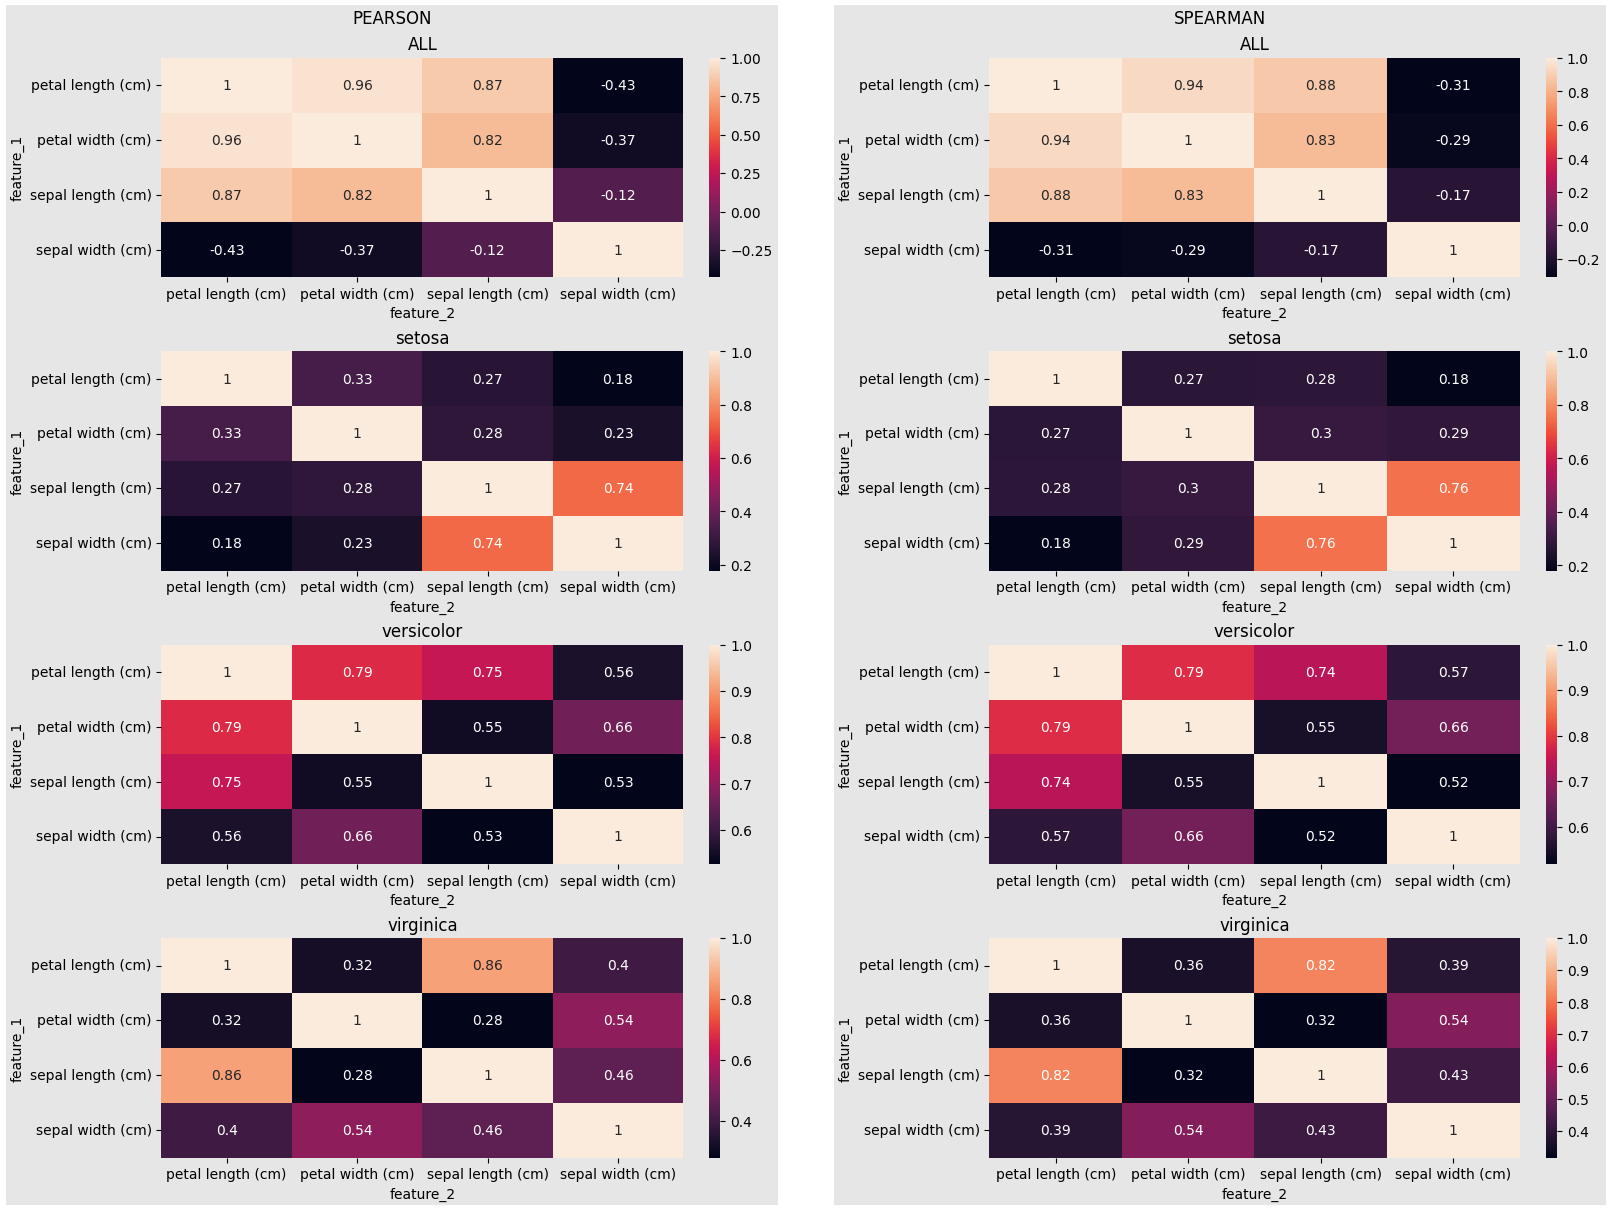

In [12]:
all_objects = df[feature_columns]
corr_matrices_fig = draw_corr_matrices(all_objects, objects_by_class, class_names)
plt.show()

### [5] Отдельно повторно выполнить пункт [3]; 
на каждом из графиков для каждого из классов отобразить линию линейной регрессии с соответствующими прогнозными интервалами регрессий (95% predictive bands).

In [13]:
def fit_linear_model(x: np.ndarray, y: np.ndarray) -> LinearRegression:
    """Фитим линейную модель"""
    linreg = LinearRegression().fit(x, y)
    return linreg

In [14]:
def compute_pred_interval(x: np.ndarray, y: np.ndarray, linreg: LinearRegression, alpha: float = 0.05) -> Tuple[np.ndarray, np.ndarray]:
    """
    Вычисление 95% predictive interval (PI)
    """
    y_pred = linreg.predict(x)
    n = len(x)
    mse = mean_squared_error(y, y_pred)
    x_mean = np.mean(x)
    sum_sq = np.sum((x - x_mean)**2)
    se_pred = np.sqrt(mse * (1 + 1/n + (x - x_mean)**2 / sum_sq))
    t_val = stats.t.ppf(1 - alpha/2, n - 2)
    return y_pred - t_val*se_pred, y_pred + t_val*se_pred

In [15]:
def plot_regression_with_pi(ax, x, y, linreg):
    """Визуализирует линейную регрессию и предсказательные интервалы"""
    y_pred = linreg.predict(x)
    lower, upper = compute_pred_interval(x, y, linreg)
    ax.scatter(x, y, alpha=0.3)
    ax.plot(x, y_pred, color='purple')
    ax.fill_between(x.flatten(), lower.flatten(), upper.flatten(), color='purple', alpha=0.2)

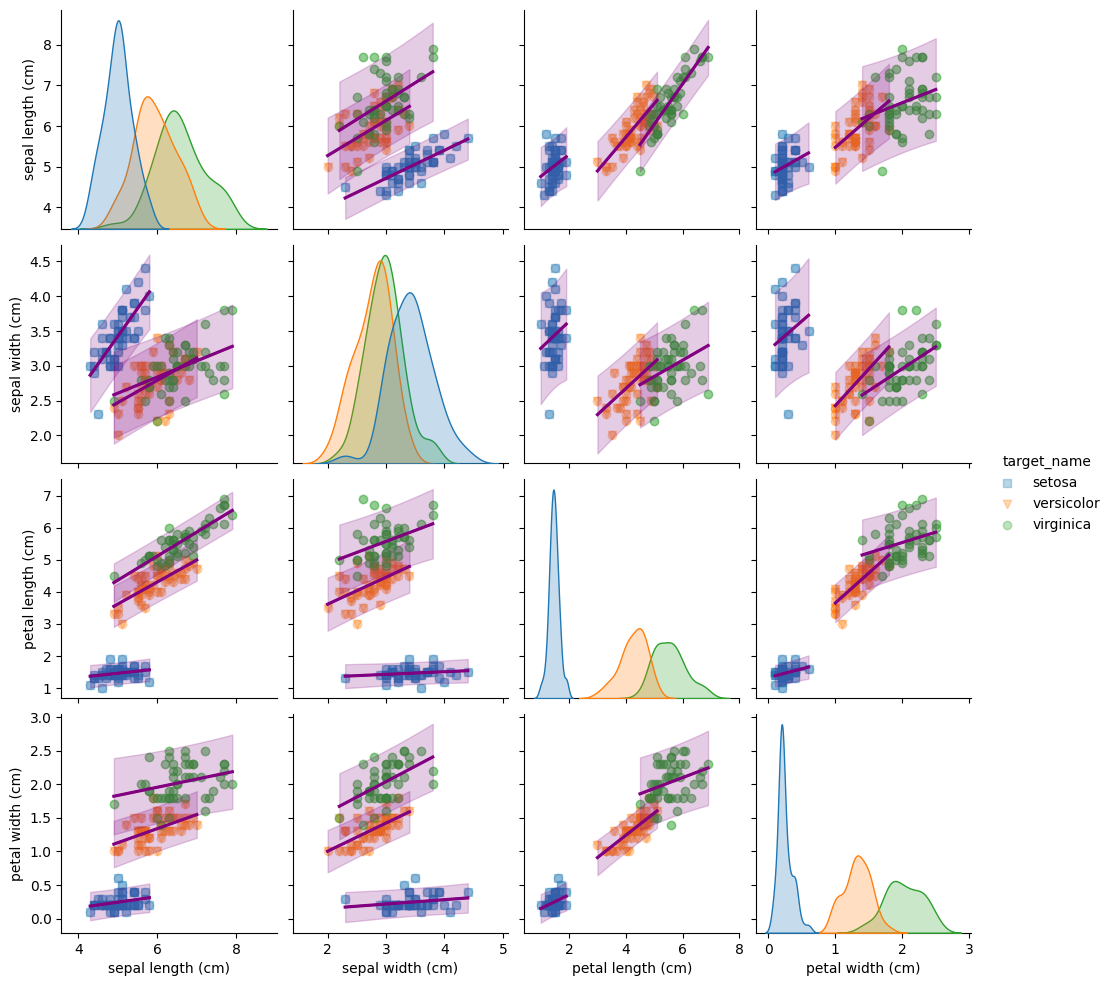

In [16]:
reg_fig = sns.pairplot(df.drop(columns='target'), 
                       kind='reg', 
                       hue='target_name', 
                       markers=['s','v','o'], 
                       plot_kws={'ci':None, 'line_kws':{'color':'purple'}, 
                                 'scatter_kws':{'alpha':0.3}}).figure

axs = reg_fig.get_axes()

for i, f1 in enumerate(feature_columns):
    for j, f2 in enumerate(feature_columns):
        if i != j:
            for cls in class_names:
                subset = objects_by_class[cls].sort_values(f1)
                x = subset[f1].values.reshape(-1,1)
                y = subset[f2].values.reshape(-1,1)
                linreg = fit_linear_model(x, y)
                plot_regression_with_pi(axs[j*4 + i], x, y, linreg)

plt.show()

### [6] Повторить пункт [5], но с доверительными интервалами регрессий (95% confidence bands).

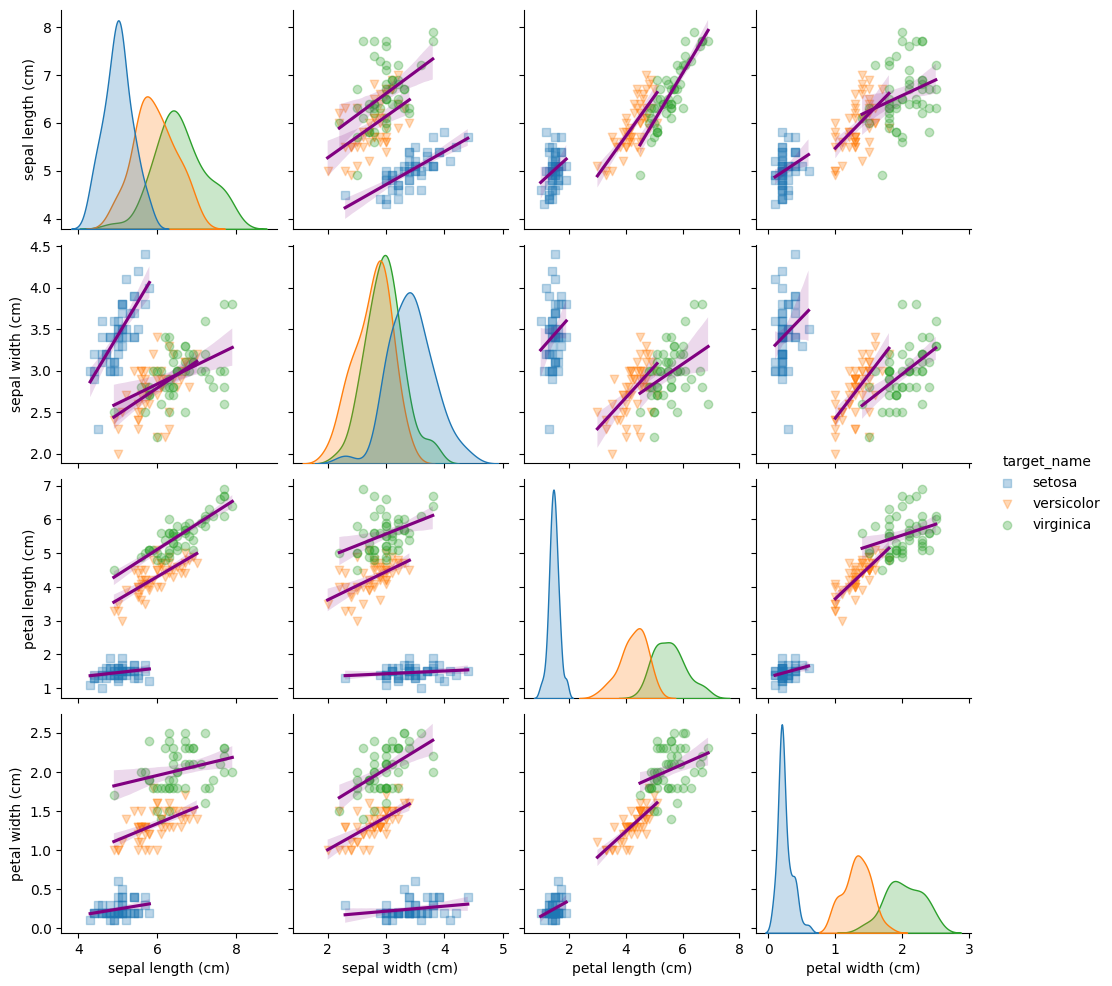

In [17]:
reg_fig = sns.pairplot(df.drop(columns='target'),
                        kind='reg',
                        hue='target_name',
                        markers=['s', 'v', 'o'],
                        plot_kws=dict(ci=95, 
                                      line_kws=dict(color="purple"), 
                                      scatter_kws=dict(alpha=0.3))).figure

plt.show()

### [7] Вывести формулы каждой линейной регрессии вместе со значениями 
- критерия R2,
- критерия Вальда (F-критерий, его степени свободы и соответствующий p-критерий),
- критерия LR (хи-квадрат-критерий, степени свободы и соответствующий p-критерий),
- критерия score (хи-квадрат-критерий, степени свободы и соответствующий p-критерий).

In [18]:
def regression_diagnostics(x, y, linreg):
    n = len(y)
    k = x.shape[1]

    # предсказания и метрики
    y_pred = linreg.predict(x)
    r2 = linreg.score(x, y)

    # --- Wald (F-тест)
    F = (r2 / k) / ((1 - r2) / (n - k - 1))
    p_val_F = 1 - stats.f.cdf(F, k, n - k - 1)

    # --- LR
    def loglik(y, y_pred):
        ssr = np.sum((y - y_pred) ** 2)
        sigma2 = ssr / n
        return -0.5 * n * (np.log(2*np.pi*sigma2) + 1)
    ll_full = loglik(y, y_pred)
    ll_restricted = loglik(y, np.full_like(y, y.mean()))
    LR = -2 * (ll_restricted - ll_full)
    p_val_LR = 1 - stats.chi2.cdf(LR, k)

    # --- Score
    resid0 = y - y.mean()
    aux = LinearRegression().fit(x, resid0)
    r2_aux = aux.score(x, resid0)
    LM = n * r2_aux
    p_val_score = 1 - stats.chi2.cdf(LM, k)

    return {
        "formula": f"y = {linreg.intercept_[0]:.3f} + {linreg.coef_[0][0]:.3f}·x",
        "R2": r2,
        "F": (F, k, n-k-1, p_val_F),
        "LR": (LR, k, p_val_LR),
        "Score": (LM, k, p_val_score),
    }

In [19]:
results_compact = []

for i, feature_name in enumerate(iris.feature_names):
    for j, next_feature_name in enumerate(iris.feature_names):
        if i != j:
            for class_name in iris.target_names:
                objs_sorted_by_feature = objects_by_class[class_name].sort_values(feature_name)
                x = objs_sorted_by_feature[feature_name].to_numpy().reshape((-1, 1))
                y = objs_sorted_by_feature[next_feature_name].to_numpy().reshape((-1, 1))

                linreg = LinearRegression().fit(x, y)
                diag = regression_diagnostics(x, y, linreg)

                results_compact.append({
                    "class_name": class_name,
                    "feature_x": feature_name,
                    "feature_y": next_feature_name,
                    "formula": diag["formula"],
                    "R2": diag["R2"],
                    "F": diag["F"][0],
                    "LR": diag["LR"][0],
                    "Score": diag["Score"][0]
                })

df_results = pd.DataFrame(results_compact)
display(df_results)

,class_name,feature_x,feature_y,formula,R2,F,LR,Score
0,setosa,sepal length (cm),sepal width (cm),y = -0.569 + 0.799·x,0.551376,58.993730,40.078461,27.568779
1,versicolor,sepal length (cm),sepal width (cm),y = 0.872 + 0.320·x,0.276582,18.351688,16.188410,13.829104
2,virginica,sepal length (cm),sepal width (cm),y = 1.446 + 0.232·x,0.209057,12.687074,11.726486,10.452864
3,setosa,sepal length (cm),petal length (cm),y = 0.803 + 0.132·x,0.071383,3.689765,3.702939,3.569144
4,versicolor,sepal length (cm),petal length (cm),y = 0.185 + 0.686·x,0.568590,63.263024,42.034799,28.429492
5,virginica,sepal length (cm),petal length (cm),y = 0.610 + 0.750·x,0.746884,141.636664,68.695447,37.344219
6,setosa,sepal length (cm),petal width (cm),y = -0.170 + 0.083·x,0.077339,4.023424,4.024653,3.866935
7,versicolor,sepal length (cm),petal width (cm),y = 0.083 + 0.209·x,0.298620,20.436482,17.735252,14.930985
8,virginica,sepal length (cm),petal width (cm),y = 1.226 + 0.121·x,0.079022,4.118483,4.115932,3.951077
9,setosa,sepal width (cm),sepal length (cm),y = 2.639 + 0.690·x,0.551376,58.993730,40.078461,27.568779


### [8] Выбрать любой количественный признак и выполнить дисперсионный анализ (ANOVA):
- Рассчитать F-критерий, его степени свободы и соответствующий ему p-критерий для всех классов одновременно;
- Рассчитать F-критерий, степени свободы и соответствующий ему p-критерий для каждой пары сравниваемых классов;
- Визуализировать выбранный количественный признак для каждого из классов в виде raincloud plot with jittering, рядом с каждым классом в виде boxplot отобразить медианы, межквартильные размахи (IQR) и 95% доверительные интервалы.

In [20]:
feature_names = iris.feature_names
class_names = iris.target_names.tolist()

objects_by_class = {cls: df[df["target_name"] == cls][feature_names] for cls in class_names}

In [21]:
def f_test(feature: str, objects_by_class: Dict[str, pd.DataFrame]):
    """ANOVA по всем классам и по парам классов"""
    values = [objects_by_class[cls][feature] for cls in class_names]
    f_stat = stats.f_oneway(*values)
    f_all = pd.DataFrame({
        "feature": [feature],
        "df_b": [len(class_names)-1],
        "df_w": [sum(len(v) for v in values) - len(class_names)],
        "F-test": [f_stat.statistic],
        "p-value": [f_stat.pvalue]
    })

    f_pairs = pd.DataFrame([{
        "feature": feature,
        "class_1": cls1,
        "class_2": cls2,
        "df_b": 1,
        "df_w": len(objects_by_class[cls1]) + len(objects_by_class[cls2]) - 2,
        "F-test": stats.f_oneway(objects_by_class[cls1][feature], objects_by_class[cls2][feature]).statistic,
        "p-value": stats.f_oneway(objects_by_class[cls1][feature], objects_by_class[cls2][feature]).pvalue
    } for cls1, cls2 in combinations(class_names, 2)])

    return f_all, f_pairs

In [22]:
def draw_raincloud_box(data, feature, hue="target_name", palette="magma"):
    plt.figure(figsize=(15, 10))

    ax = sns.violinplot(
        x=feature,
        y=hue,
        hue=hue,
        palette=palette,
        data=data,
        cut=0,
        inner=None,
        alpha=0.5
    )

    for item in ax.collections:
        x0, y0, width, height = item.get_paths()[0].get_extents().bounds
        item.set_clip_path(
            plt.Rectangle((x0, y0), width, height/2, transform=ax.transData)
        )

    num_items = len(ax.collections)
    sns.stripplot(
        x=feature,
        y=hue,
        hue=hue,
        data=data,
        palette=palette,
        alpha=0.4,
        size=7
    )

    for item in ax.collections[num_items:]:
        item.set_offsets(item.get_offsets() + 0.15)

    sns.boxplot(
        x=feature,
        y=hue,
        data=data,
        width=0.25,
        showfliers=False,
        showmeans=True,
        meanprops=dict(marker='o', markerfacecolor='darkorange', markersize=10, zorder=3),
        boxprops=dict(facecolor=(0,0,0,0), linewidth=3, zorder=3),
        whiskerprops=dict(linewidth=3),
        capprops=dict(linewidth=3),
        medianprops=dict(linewidth=3)
    )

    plt.title(f"Raincloud plot for {feature}", fontsize=18)
    plt.show()

sepal length (cm) - All classes ANOVA:


,feature,df_b,df_w,F-test,p-value
0,sepal length (cm),2,147,119.264502,1.669669e-31


sepal length (cm) - Pairwise ANOVA:


,feature,class_1,class_2,df_b,df_w,F-test,p-value
0,sepal length (cm),setosa,versicolor,1,98,110.691152,8.985235e-18
1,sepal length (cm),setosa,virginica,1,98,236.735022,6.892546e-28
2,sepal length (cm),versicolor,virginica,1,98,31.687502,1.724856e-07


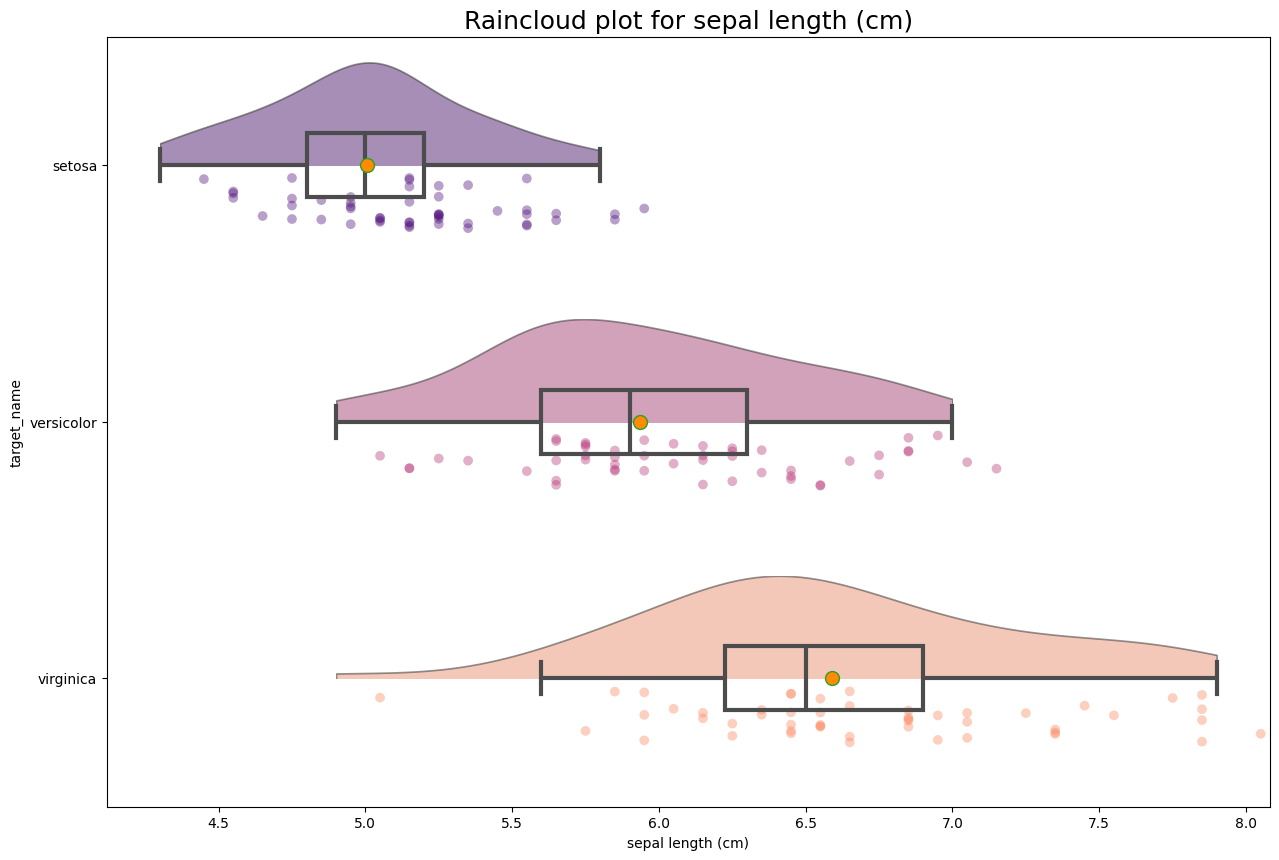

sepal width (cm) - All classes ANOVA:


,feature,df_b,df_w,F-test,p-value
0,sepal width (cm),2,147,49.16004,4.492017e-17


sepal width (cm) - Pairwise ANOVA:


,feature,class_1,class_2,df_b,df_w,F-test,p-value
0,sepal width (cm),setosa,versicolor,1,98,89.396568,1.845260e-15
1,sepal width (cm),setosa,virginica,1,98,41.607003,4.246355e-09
2,sepal width (cm),versicolor,virginica,1,98,10.276902,1.819100e-03


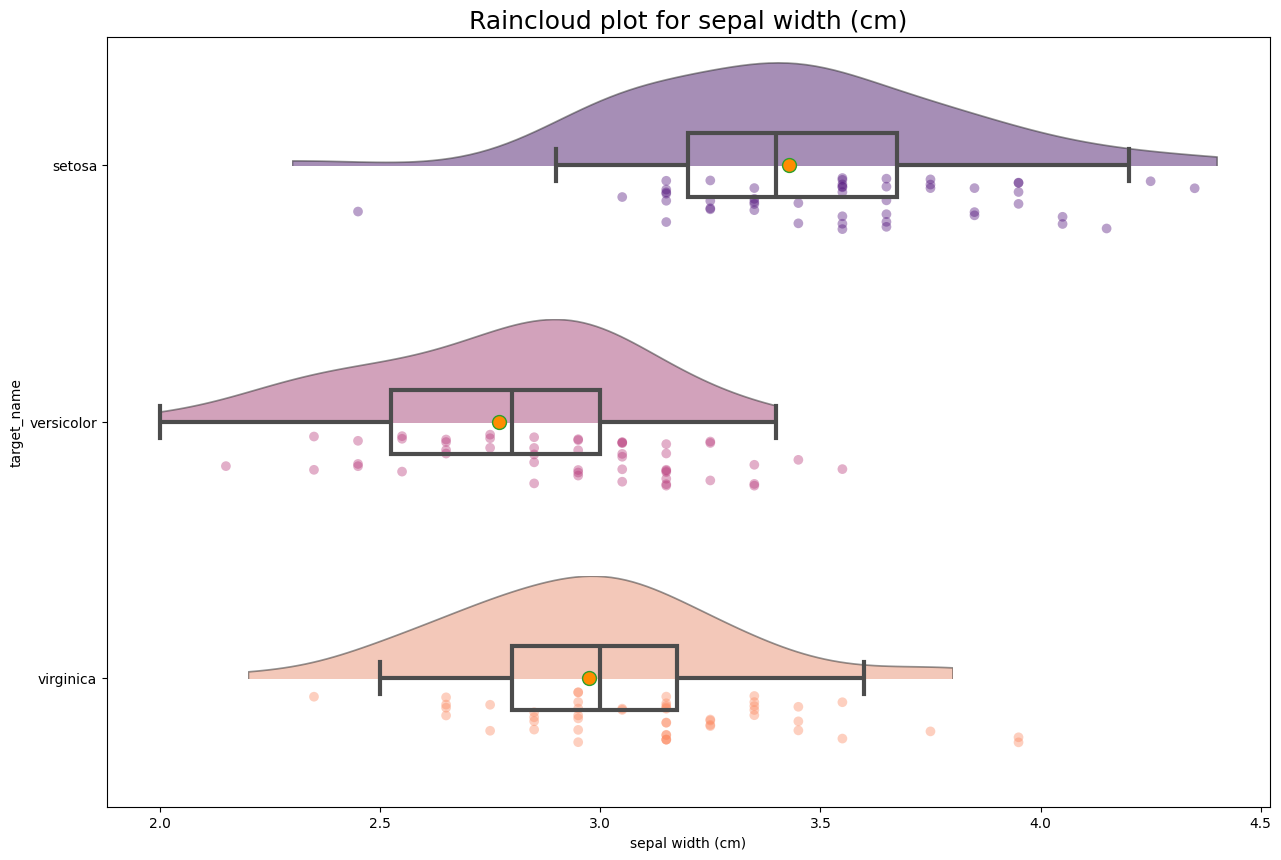

petal length (cm) - All classes ANOVA:


,feature,df_b,df_w,F-test,p-value
0,petal length (cm),2,147,1180.161182,2.856777e-91


petal length (cm) - Pairwise ANOVA:


,feature,class_1,class_2,df_b,df_w,F-test,p-value
0,petal length (cm),setosa,versicolor,1,98,1559.674885,5.404911e-62
1,petal length (cm),setosa,virginica,1,98,2498.618817,1.504801e-71
2,petal length (cm),versicolor,virginica,1,98,158.855256,3.178820e-22


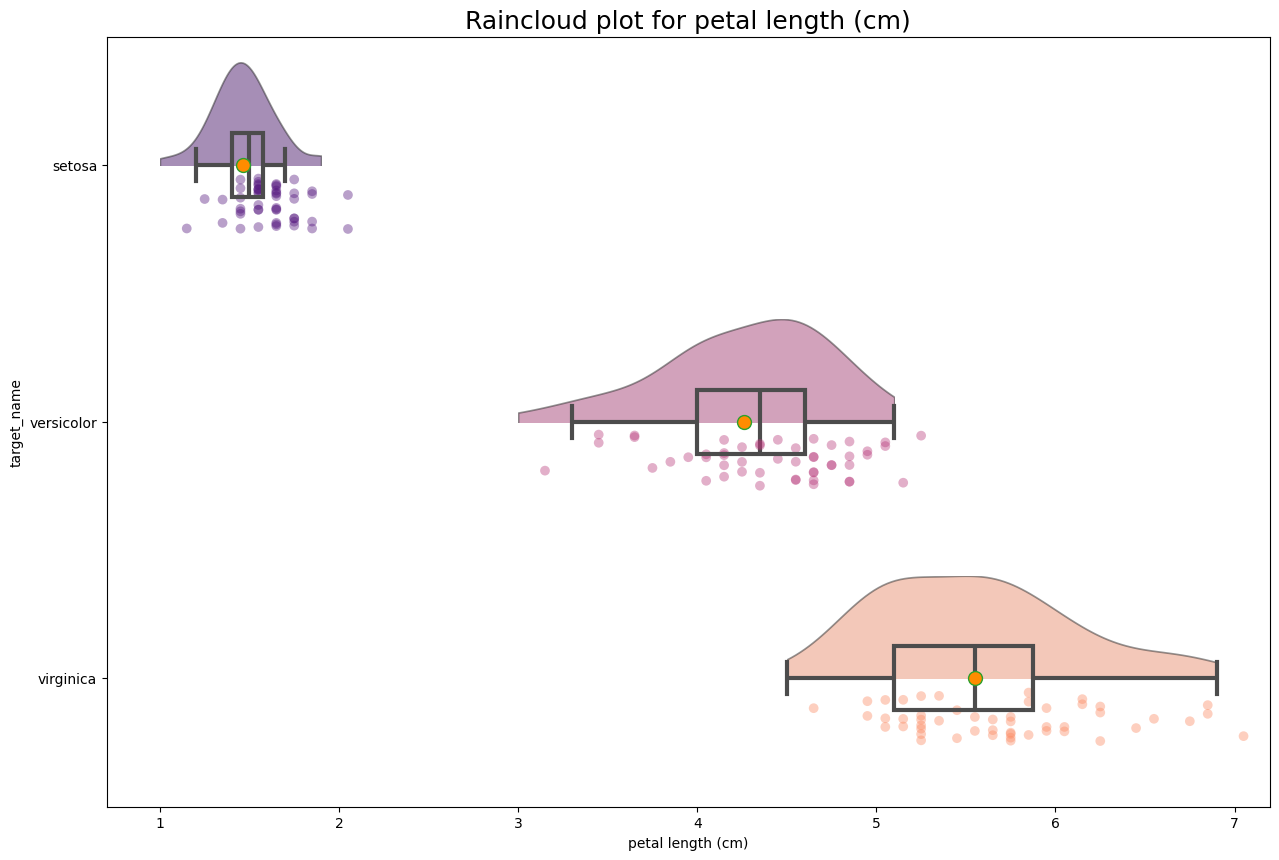

petal width (cm) - All classes ANOVA:


,feature,df_b,df_w,F-test,p-value
0,petal width (cm),2,147,960.007147,4.169446e-85


petal width (cm) - Pairwise ANOVA:


,feature,class_1,class_2,df_b,df_w,F-test,p-value
0,petal width (cm),setosa,versicolor,1,98,1161.469680,3.831095e-56
1,petal width (cm),setosa,virginica,1,98,1830.624469,3.230375e-65
2,petal width (cm),versicolor,virginica,1,98,213.901361,2.230409e-26


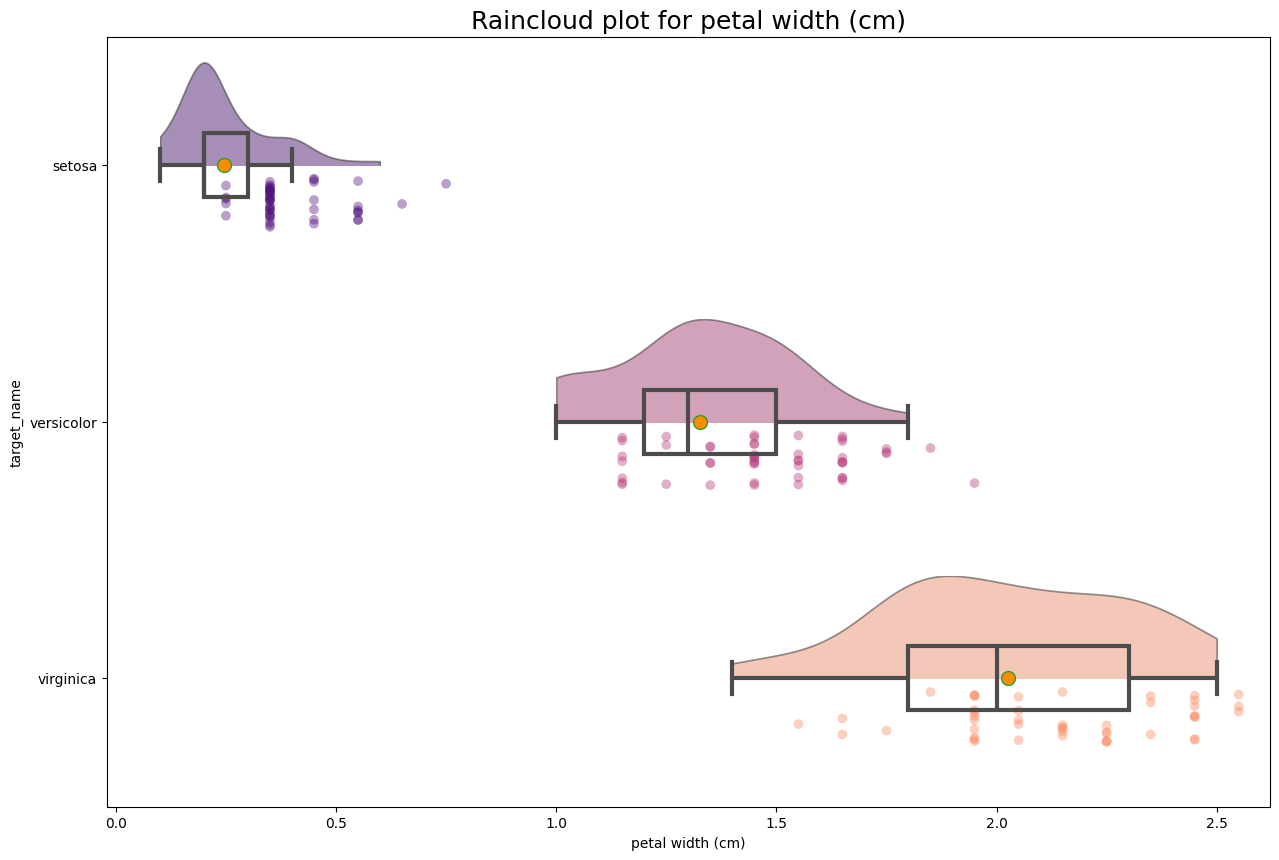

In [24]:
for feature in feature_columns:
    f_all, f_pairs = f_test(feature, objects_by_class)
    print(f"{feature} - All classes ANOVA:")
    display(f_all)
    print(f"{feature} - Pairwise ANOVA:")
    display(f_pairs)

    draw_raincloud_box(df, feature, hue="target_name", palette="magma")